In [1]:
print("testing transfer learning from resnet18 to annotations")

testing transfer learning from resnet18 to annotations


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import torchnet as tnt

plt.ion()

print("imports 1 complete")

imports 1 complete


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# data_dir = "C:\\Users\\rahul\\Documents\\work\\BuildUCLA\\data\\printed_with_ids\\images"
data_dir = "C:\\Users\\rahul\\Documents\\work\\BuildUCLA\\data\\printed_with_ids_harsh_filter\\images"


set_types = ['train', 'val', 'test']

# Need to split data sets into training and testing sets
data_sets = {t : datasets.ImageFolder(data_dir, transform=data_transforms[t])
             for t in set_types}

# Need to split data into training set, validation set, and testing set
train_size = 0.65     # 65% of all data is training
val_size = 0.15       # 15% of all data is validation
test_size = (1 - train_size - val_size)    # Remaining data (20%) is testing

num_images = len(data_sets["train"]) # length of both sets should be the same
all_ind = list(range(num_images))
random_seed = 11
np.random.seed(random_seed)
np.random.shuffle(all_ind)

train_split = int(num_images * train_size)
val_split = int(num_images * val_size)
test_split = int(num_images * test_size)

data_samplers = {}
data_samplers["train"] = all_ind[:train_split]
data_samplers["val"] = all_ind[train_split : train_split+val_split]
data_samplers["test"] = all_ind[train_split+val_split:]

dataloaders = {t : torch.utils.data.DataLoader(data_sets[t],
                                              sampler=data_samplers[t],
                                              batch_size=4,
                                              num_workers=4)
              for t in set_types}

dataset_sizes = {t : len(data_samplers[t]) for t in set_types}

class_names = data_sets["train"].classes
use_gpu = torch.cuda.is_available()

print("data loaded from " + str(data_dir))
print("read classes: " + str(class_names))
if use_gpu:
    print("use_gpu is true")
else:
    print("use_gpu is false")

data loaded from C:\Users\rahul\Documents\work\BuildUCLA\data\printed_with_ids_harsh_filter\images
read classes: ['negative', 'positive']
use_gpu is true


visualized a few images


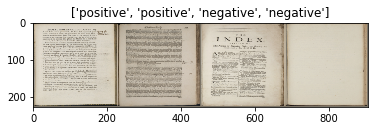

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

print("visualized a few images")

In [5]:
print("This 'train_model' function is a generic routine that can be used to train various models.")

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Confusion matrix
            confusion_matrix = tnt.meter.ConfusionMeter(2)

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                # Add to confusion matrix
                confusion_matrix.add(outputs.data, labels.data)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            # save each epoch's model
#             weights_path = "resnet18_half_frozen_" + str(epoch + 1) + "epochs_transfer-state.pt"
#             torch.save(model_resnet18.state_dict(), weights_path)
#             print("saved epoch " + str(epoch + 1) + " model state (weights) to " + weights_path)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Print confusion matrix
            print(confusion_matrix.conf)
            print()

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        
        # Extra spacing
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

This 'train_model' function is a generic routine that can be used to train various models.


In [6]:
print("Transferring resnet18 and retraining with annotations dataset.")

model_resnet18 = models.resnet18(pretrained=True)
num_params = sum(1 for i in model_resnet18.parameters())

# There are 10 layers (model_ft.children()) in resnet18
# Freezing the first half of resnet18, freezing all params for layers 1-5
max_layer = 5
curr_layer = 1
last_layer = None
for child in model_resnet18.children():
    if curr_layer <= max_layer:
        for param in child.parameters():
            param.requires_grad = False
        last_layer = child
        curr_layer = curr_layer + 1
    else:
        break
        
# for child in model.children():
#     print("")
#     print(child)
        
# Replace the final fully connected layer to perform binary classification
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_resnet18 = model_resnet18.cuda()

criterion = nn.CrossEntropyLoss()

# Need to create slightly custom optimizer since half of the layers are frozen
optimizer = optim.SGD(list(filter(lambda p: p.requires_grad, model_resnet18.parameters())), lr=0.001, momentum=0.9)

# Create LR scheduler that decays LR by a factor of 0.1 for every 7 epochs (this is from tutorial, might need tweaking)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("Created new model to train")

Transferring resnet18 and retraining with annotations dataset.
Created new model to train


In [7]:
print("perform training")
num_training_epochs = 10

model_resnet18 = train_model(model_resnet18, criterion, optimizer, exp_lr_scheduler, num_epochs=num_training_epochs)

print("training complete")

perform training
Epoch 0/9
----------
train Loss: 0.6133 Acc: 0.7462
[[ 223  267]
 [ 198 1144]]

val Loss: 0.3155 Acc: 0.8863
[[ 77  32]
 [ 16 297]]



Epoch 1/9
----------
train Loss: 0.3352 Acc: 0.8597
[[ 359  131]
 [ 126 1216]]

val Loss: 0.3614 Acc: 0.8555
[[ 69  40]
 [ 21 292]]



Epoch 2/9
----------
train Loss: 0.1674 Acc: 0.9432
[[ 438   52]
 [  52 1290]]

val Loss: 0.4186 Acc: 0.8815
[[ 71  38]
 [ 12 301]]



Epoch 3/9
----------
train Loss: 0.1150 Acc: 0.9667
[[ 460   30]
 [  31 1311]]

val Loss: 0.5557 Acc: 0.8507
[[ 55  54]
 [  9 304]]



Epoch 4/9
----------
train Loss: 0.1112 Acc: 0.9711
[[ 465   25]
 [  28 1314]]

val Loss: 0.4450 Acc: 0.8720
[[ 75  34]
 [ 20 293]]



Epoch 5/9
----------
train Loss: 0.0963 Acc: 0.9793
[[ 472   18]
 [  20 1322]]

val Loss: 0.4844 Acc: 0.8460
[[ 91  18]
 [ 47 266]]



Epoch 6/9
----------
train Loss: 0.1006 Acc: 0.9733
[[ 466   24]
 [  25 1317]]

val Loss: 0.5269 Acc: 0.8483
[[ 84  25]
 [ 39 274]]



Epoch 7/9
----------
train Loss: 0.074

In [ ]:
# weights_path = "resnet18_half_frozen_5epochs_transfer-state.pt"
# torch.save(model_resnet18.state_dict(), weights_path)
# print("saved model state (weights) to " + weights_path)

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

visualize_model(model_resnet18)
print("visualizing model")

In [ ]:
print("running on testing dataset")
model_resnet18.train(False)  # Set model to evaluate mode

running_loss = 0.0
running_corrects = 0

criterion = nn.CrossEntropyLoss()

# Iterate over data.
for data in dataloaders["test"]:
    # get the inputs
    inputs, labels = data

    # wrap them in Variable
    if use_gpu:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)

    # zero the parameter gradients
#     optimizer.zero_grad()

    # forward
    outputs = model_resnet18(inputs)
    _, preds = torch.max(outputs.data, 1)
    loss = criterion(outputs, labels)

    # backward + optimize only if in training phase
#     if phase == 'train':
#         loss.backward()
#         optimizer.step()

    # statistics
    running_loss += loss.data[0] * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

epoch_loss = running_loss / dataset_sizes["test"]
epoch_acc = running_corrects / dataset_sizes["test"]

print('{} Loss: {:.4f} Acc: {:.4f}'.format(
    "test", epoch_loss, epoch_acc))